In [1]:
import polars as pl
import seaborn as sns
import gcld3

In [3]:
reviews = pl.scan_csv('../data/long_reviews.csv')

In [4]:
reviews.schema

{'age': Utf8,
 'author': Utf8,
 'author_review_count': Utf8,
 'rating': Utf8,
 'review_text': Utf8}

In [5]:
print(reviews.select('review_text').head().collect().to_pandas().iloc[2][0])

(Translated by Google) The food is tasty, but by the chef, one star is too much. The Lord is clearly dissatisfied with the presence of customers. He comments loudly all the time and complains until he refuses to eat and be there. We will definitely not be going back there and we will not recommend it !!!

(Original)
Jedzenie smaczne,  ale przez pana z kuchni jedna gwiazdka to za dużo. Pan ewidentnie jest niezadowolny z obecności klientów. Cały czas głośno komentuje i narzeka aż się odechciewa jeść i tam przebywać. Na pewno tam nie wrócimy i nie będziemy polecać!!!


In [6]:
pattern = r'(\(Translated by Google\))([\S\s]+)(\(Original\))([\S\s]+)'
detector = gcld3.NNetLanguageIdentifier(min_num_bytes=0, max_num_bytes=1024)

reviews_edited = (
    reviews
    .filter(pl.col('rating').str.contains(r'^[1-5]/5$|[1-5] star'))
    .with_column(pl.col('rating').str.extract(r'[1-5]', 0).cast(pl.Int32))
    .with_column(pl.col('author_review_count').str.extract(r'(\d+)( review)', 1).cast(pl.Int32))
    .with_column(pl.col('review_text').str.extract(pattern, 2).str.strip().alias('translated'))
    .with_column(pl.col('review_text').str.extract(pattern, 4).str.strip().alias('original'))
    .with_column(
        pl.when(pl.col('translated').is_null())
        .then(pl.col('review_text'))
        .otherwise(pl.col('original')).alias('original')
    )
    .with_column(
        pl.col('original')
        .apply(lambda x: detector.FindLanguage(text=x))
        .alias('detection_result')
    )
    .with_column(
        pl.col('detection_result')
        .apply(lambda x: x.language)
        .alias('language')
    )
    .with_column(
        pl.col('detection_result')
        .apply(lambda x: x.probability)
        .alias('language_prob')
    )
    .drop('detection_result')
    .collect()
)

<AxesSubplot: ylabel='Count'>

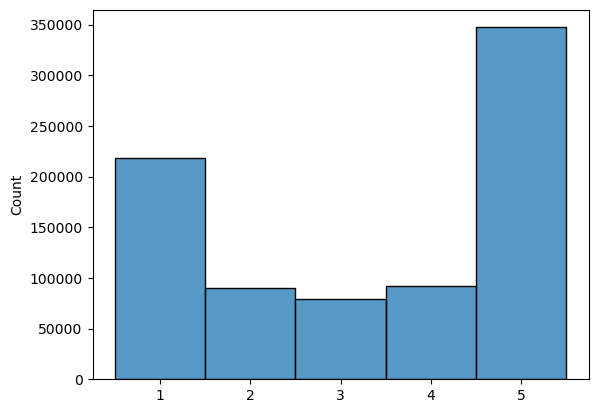

In [7]:
ratings = reviews_edited.select('rating').to_numpy().ravel()
sns.histplot(x=ratings, discrete=True)

In [8]:
(
    reviews_edited
    .groupby('language')
    .agg(pl.lit(1).count().alias('count'))
    .sort('count', reverse=True)
    .head(10)
)

language,count
str,u32
"""pl""",792971
"""de""",10600
"""en""",7697
"""ru""",6386
"""uk""",1862
"""it""",1712
"""es""",1319
"""fr""",1119
"""cs""",902


In [19]:
polish_reviews = (
    reviews_edited
    .filter(
        (pl.col('language') == 'pl')
        & (pl.col('language_prob') > 0.5)
        & (pl.col('translated').is_not_null())
    )
)

reviews_sample = (
    polish_reviews
    .filter(
        pl.arange(0, pl.count()).shuffle(seed=123).over('rating') < 62500
    )
)

In [15]:
reviews_sample.head()

age,author,author_review_count,rating,review_text,translated,original,language,language_prob
str,str,i32,i32,str,str,str,str,f64
"""5 months ago""","""Zet Zet""",17,2,"""(Translated by...","""The quality of...","""Jakość jedzeni...","""pl""",1.0
"""9 months ago""","""Ewka Klyz""",1,1,"""(Translated by...","""The food is ta...","""Jedzenie smacz...","""pl""",1.0
"""a year ago""","""Justyna Krasa""",2,1,"""(Translated by...","""I am amazed at...","""Jestem zdumion...","""pl""",0.999998
"""a year ago""","""Piotr Góral""",117,3,"""(Translated by...","""Big question m...","""Duży znak zapy...","""pl""",0.999989
"""3 years ago""","""Gabriela""",50,4,"""(Translated by...","""A place with g...","""Lokal z dużym ...","""pl""",1.0


In [64]:
reviews_sample.drop('review_text').write_csv('reviews_sample.csv')

In [20]:
reviews_sample.drop('review_text').write_parquet('../data/reviews_sample.parquet')